# 循环神经网络(Recurrent Neural Network, RNN)

## RNN手写字体分类

### 导入相关库

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import copy
import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision 
import torch.utils.data as Data
from torchvision import transforms
import hiddenlayer as hl

### 数据集

MNIST数据集由0~9的数字图像构成，训练图像有6万张，测试图像有1万张。  
单张图像为灰度图像，尺寸为: 28x28。

### code

In [2]:
# 训练数据集
train_data = torchvision.datasets.MNIST(
    root = "../data/MNIST",
    train = True,
    transform = transforms.ToTensor(),
    download = True
)
# 定义数据加载器
train_loader = Data.DataLoader(
    dataset = train_data, 
    batch_size = 64,
    shuffle = True, 
    num_workers = 2
)
# 准备需要的测试数据集
test_data = torchvision.datasets.MNIST(
    root = "../data/MNIST",
    train = False, 
    transform = transforms.ToTensor(),
    download = False
)

test_loader = Data.DataLoader(
    dataset = test_data,
    batch_size = 64,
    shuffle = True,
    num_workers = 2
)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|█████████████████████████████████████████████████████████████████████████████| 9.91M/9.91M [00:03<00:00, 2.83MB/s]


Extracting ../data/MNIST\MNIST\raw\train-images-idx3-ubyte.gz to ../data/MNIST\MNIST\raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████████████████████████████████████████████████████████████████████████| 28.9k/28.9k [00:00<00:00, 104kB/s]


Extracting ../data/MNIST\MNIST\raw\train-labels-idx1-ubyte.gz to ../data/MNIST\MNIST\raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████████████████████████████████████████████████████████████████████████| 1.65M/1.65M [00:02<00:00, 571kB/s]


Extracting ../data/MNIST\MNIST\raw\t10k-images-idx3-ubyte.gz to ../data/MNIST\MNIST\raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|█████████████████████████████████████████████████████████████████████████████| 4.54k/4.54k [00:00<00:00, 1.52MB/s]


Extracting ../data/MNIST\MNIST\raw\t10k-labels-idx1-ubyte.gz to ../data/MNIST\MNIST\raw



In [3]:
class RNNimc( nn.Module ):
    def __init__ (self,input_dim, hidden_dim,layer_dim, output_dim):
        """
            input_dim: 输入数据的维度（图片每行的数据像素点
            hidden_dim : RNN神经元个数
            layer_dim: RNN的层数
            output_dim: 隐藏层输出的维度（分类的数量
        """
        super(RNNimc,self).__init__()
        self.hidden_dim = hidden_dim # RNN神经元个数
        self.layer_dim = layer_dim # RNN的层数
        # RNN
        self.rnn = nn.RNN(input_dim, hidden_dim, layer_dim, batch_first=True, nonlinearity='relu')
        # 连接全连接层
        self.fc1 = nn.Linear(hidden_dim,output_dim)
    def forward(self,x):
        # x:[batch,time_step,input_dim]
        # time_step = 图像所有像素数量/input_dim
        # out: [bacth, time_step, output_size]
        # h_n:[layer_dim, batch,hidden_dim]
        # None表示h0会使用全0进行初始化
        out,h_n = self.rnn(x,None)
        # 选取最后一个时间点的out输出
        out = self.fc1(out[:,-1,:])
        return out

In [5]:
# 模型调用
input_dim = 28 # 图片每行的像素数量
hidden_dim = 128 # RNN神经元个数
layer_dim = 1 # RNN的层数
output_dim = 10 # 隐藏层输出的维度(10类图像)
MyRNNimc = RNNimc(input_dim, hidden_dim, layer_dim, output_dim)
print( MyRNNimc )

RNNimc(
  (rnn): RNN(28, 128, batch_first=True)
  (fc1): Linear(in_features=128, out_features=10, bias=True)
)


In [7]:
# 对模型进行训练
optimizer = torch.optim.RMSprop(MyRNNimc.parameters(), lr = 0.0003)
criterion = nn.CrossEntropyLoss() # 损失函数
train_loss_all = []
train_acc_all = []
test_loss_all = []
test_acc_all = []
num_epochs = 30
for epoch in range( num_epochs):
    print("Epoch {}/{}".format(epoch,num_epochs-1))
    MyRNNimc.train() # 设置模型为训练模式
    corrects = 0
    train_num = 0
    for step,(b_x,b_y) in enumerate( train_loader ):
        # input : [batch, time_step, input_dim ]
        xdata = b_x.view(-1,28,28)
        output = MyRNNimc( xdata )
        pre_lab = torch.argmax( output,1)
        loss = criterion(output, b_y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        loss += loss.item() * b_x.size(0)
        corrects += torch.sum( pre_lab == b_y.data )
        train_num += b_x.size(0)
    # 计算经过一个epoch的训练后在训练集上的损失和精度
    train_loss_all.append(loss/train_num)
    train_acc_all.append(corrects.double().item() / train_num )
    print("{} Train Loss: {:.4f} Train Acc: {:.4f}".format(epoch, train_loss_all[-1],train_acc_all[-1]))
    # 设置模型为验证模式
    MyRNNimc.eval()
    corrects = 0
    test_num = 0
    for step,(b_x,b_y) in enumerate( test_loader ):
        # input : [batch, time_step, input_dim ]
        xdata = b_x.view(-1,28,28)
        output = MyRNNimc( xdata )
        pre_lab = torch.argmax( output,1)
        loss = criterion(output, b_y)
        loss += loss.item() * b_x.size(0)
        corrects += torch.sum( pre_lab == b_y.data )
        test_num += b_x.size(0)
    # 计算经过一个epoch的训练后在测试集上的损失和精度
    test_loss_all.append(loss/test_num)
    test_acc_all.append(corrects.double().item() / test_num )
    print("{} Train Loss: {:.4f} Train Acc: {:.4f}".format(epoch, test_loss_all[-1],test_acc_all[-1]))
    

Epoch 0/29
0 Train Loss: 0.0003 Train Acc: 0.6851
0 Train Loss: 0.0019 Train Acc: 0.8045
Epoch 1/29
1 Train Loss: 0.0003 Train Acc: 0.8188
1 Train Loss: 0.0008 Train Acc: 0.8615
Epoch 2/29
2 Train Loss: 0.0002 Train Acc: 0.8717
2 Train Loss: 0.0006 Train Acc: 0.8858
Epoch 3/29
3 Train Loss: 0.0002 Train Acc: 0.9061
3 Train Loss: 0.0008 Train Acc: 0.8680
Epoch 4/29
4 Train Loss: 0.0001 Train Acc: 0.9283
4 Train Loss: 0.0006 Train Acc: 0.9322
Epoch 5/29
5 Train Loss: 0.0001 Train Acc: 0.9411
5 Train Loss: 0.0005 Train Acc: 0.9391
Epoch 6/29
6 Train Loss: 0.0000 Train Acc: 0.9482
6 Train Loss: 0.0000 Train Acc: 0.9584
Epoch 7/29
7 Train Loss: 0.0000 Train Acc: 0.9539
7 Train Loss: 0.0006 Train Acc: 0.9559
Epoch 8/29
8 Train Loss: 0.0000 Train Acc: 0.9590
8 Train Loss: 0.0000 Train Acc: 0.9601
Epoch 9/29
9 Train Loss: 0.0000 Train Acc: 0.9615
9 Train Loss: 0.0006 Train Acc: 0.9640
Epoch 10/29
10 Train Loss: 0.0000 Train Acc: 0.9643
10 Train Loss: 0.0001 Train Acc: 0.9639
Epoch 11/29
11 Tra

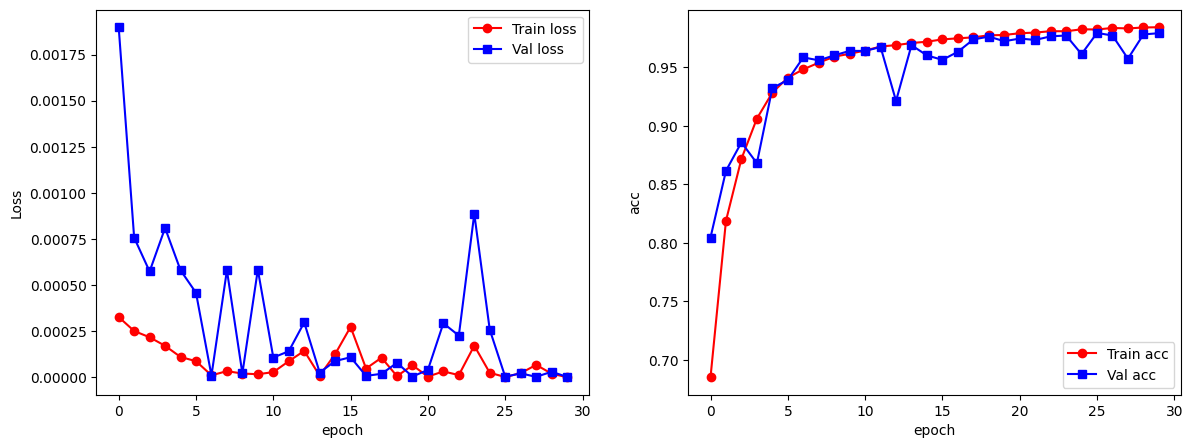

In [25]:
# 可视化模型训练过程
plt.figure(figsize=(14,5))
plt.subplot(1,2,1)
# for i in range(len(train_loss_all)):
#     train_loss_all[i] = train_loss_all[i].double().item()
# for i in range(len(test_loss_all)):
#     test_loss_all[i] = test_loss_all[i].double().item()
plt.plot(train_loss_all,"ro-",label="Train loss")
plt.plot(test_loss_all,"bs-",label="Val loss")
plt.legend()
plt.xlabel("epoch")
plt.ylabel("Loss")
plt.subplot(1,2,2)
plt.plot(train_acc_all,"ro-",label="Train acc")
plt.plot(test_acc_all,"bs-",label="Val acc")
plt.xlabel("epoch")
plt.ylabel("acc")
plt.legend()
plt.show()